In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
from PIL import Image
import powerlaw

from multiple_bonds_parsing import get_dt, compute_coordination_numbers, create_atom_df
%matplotlib inline

In [3]:
directory = r"\\wsl$\Ubuntu-18.04\home\arlenlex\LIGGGHTS_SEAICE\lexi_tests\floe_testing\shear_floe\post"
log_file_path = r"\\wsl$\Ubuntu-18.04\home\arlenlex\LIGGGHTS_SEAICE\lexi_tests\floe_testing\shear_floe\log.liggghts"
# df_atom = create_atom_df(directory)
dt = get_dt(log_file_path)

In [4]:
def compute_fragments(bond_directory):
    bond_files = sorted(glob.glob(bond_directory + r'\*.bond'))
    fragments_per_timestep = {}

    Graphs = []
    G = nx.Graph()  # Main graph that keeps track of all atoms and bonds
    
    # Set to track all atoms that have appeared in the simulation
    all_atoms = set()

    for bond_file in bond_files:
        with open(bond_file, 'r') as file:
            g = nx.Graph()
            # Create a graph for each timestep
            lines = file.readlines()

            timestep = int(lines[1].strip())
            num_entries = int(lines[3].strip())

            # Add all atoms as nodes if not already added
            for i in range(9, 9 + num_entries):
                bond_data = list(map(float, lines[i].strip().split()))
                batom1 = int(bond_data[6])
                batom2 = int(bond_data[7])
                bond_broken = int(bond_data[8])  # 1 if bond is broken, 0 otherwise

                # Add atoms to the set of all atoms
                all_atoms.update([batom1, batom2])
                
                # Add atom nodes to both G and g
                G.add_node(batom1)
                G.add_node(batom2)
                g.add_node(batom1)
                g.add_node(batom2)

                # If bond is not broken, add the edge (bond)
                if bond_broken == 0:
                    G.add_edge(batom1, batom2)
                    g.add_edge(batom1, batom2)
                else:
                    # If the bond is broken, remove the edge if it exists
                    if G.has_edge(batom1, batom2):
                        G.remove_edge(batom1, batom2)
                    if g.has_edge(batom1, batom2):
                        g.remove_edge(batom1, batom2)

            # Ensure all atoms ever seen are still present in the graph
            for atom in all_atoms:
                G.add_node(atom)
                g.add_node(atom)

            # After processing all bonds, compute the number of connected components & save the graph
            Graphs.append(g)
            num_fragments = nx.number_connected_components(G)
            fragments_per_timestep[timestep] = num_fragments
    
    return fragments_per_timestep, Graphs

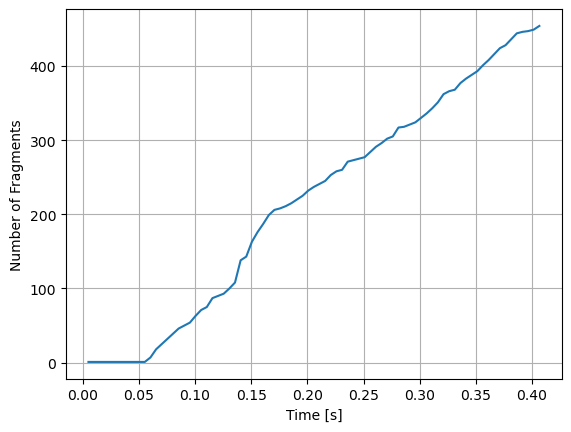

In [5]:
# Compute the number of fragments at each timestep
fragments_per_timestep, Graphs = compute_fragments(directory)

# Extract timesteps and number of fragments
timesteps = list(fragments_per_timestep.keys())
num_fragments = list(fragments_per_timestep.values())

# Plot the number of fragments over time
plt.figure()
plt.plot(np.array(timesteps)*dt, num_fragments, label='Number of Fragments')
plt.xlabel('Time [s]')
plt.ylabel('Number of Fragments')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

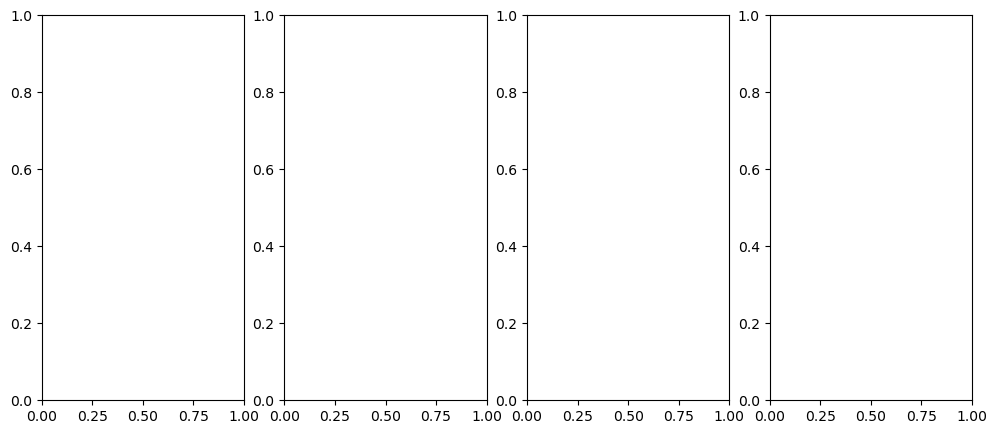

In [6]:
fig,ax=plt.subplots(1,4, figsize=(12,5))
nx.draw(Graphs[0], ax = ax[0], node_size=5, node_color = 'red', pos = nx.kamada_kawai_layout(Graphs[0]))
nx.draw(Graphs[10], ax = ax[1], node_size=5, node_color = 'red', pos = nx.kamada_kawai_layout(Graphs[0]))
nx.draw(Graphs[20], ax = ax[2], node_size=5, node_color = 'red', pos = nx.kamada_kawai_layout(Graphs[0]))
nx.draw(Graphs[30], ax = ax[3], node_size=5, node_color = 'red', pos = nx.kamada_kawai_layout(Graphs[0]))

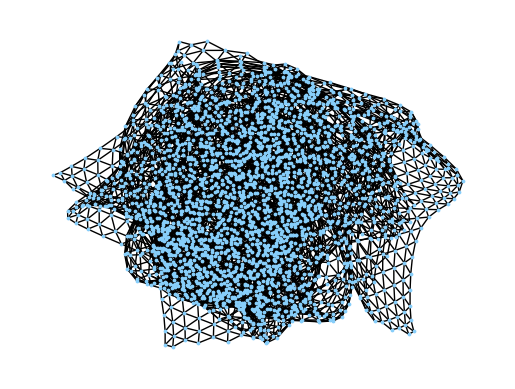

In [51]:
fig, ax = plt.subplots()


def update(frame):
    ax.clear()
    nx.draw(Graphs[frame], ax = ax, node_size=3, node_color = 'lightskyblue', pos = nx.spring_layout(Graphs[frame]))

anim = FuncAnimation(fig, update, frames = len(Graphs))
anim.save('gifs/graphs/shear_test_005_damp_spring_graph_1m.gif', writer='pillow', fps = 3)

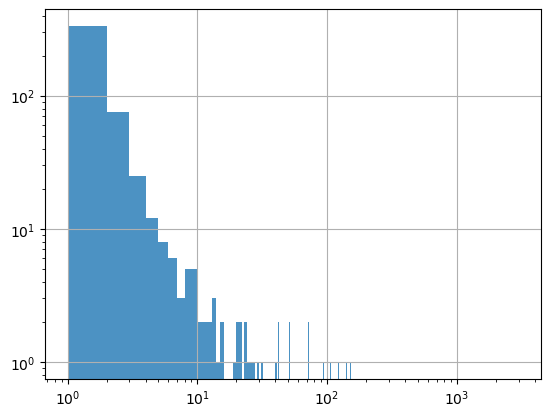

In [12]:
fig, ax = plt.subplots()
connected_components = list(nx.connected_components(Graphs[-1]))
component_sizes = np.array([len(component) for component in connected_components])
ax.hist(component_sizes, bins=np.arange(1, 3000, 1), alpha = 0.8)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

In [48]:
hist

array([411,  37,  14, ...,   0,   0,   0])

Text(0, 0.5, '# floes')

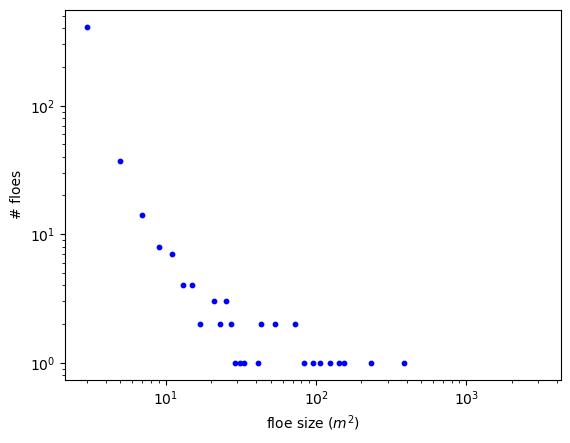

In [47]:
hist, bin_edges = np.histogram(component_sizes, bins=np.arange(1, 3000, 2))
plt.scatter(bin_edges[1:], hist, s = 10, color = 'b')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'floe size ($m^2$)')
plt.ylabel(r'# floes')

Calculating best minimal value for power law fit
c:\Users\arlenlex\AppData\Local\miniconda3\envs\graphs\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


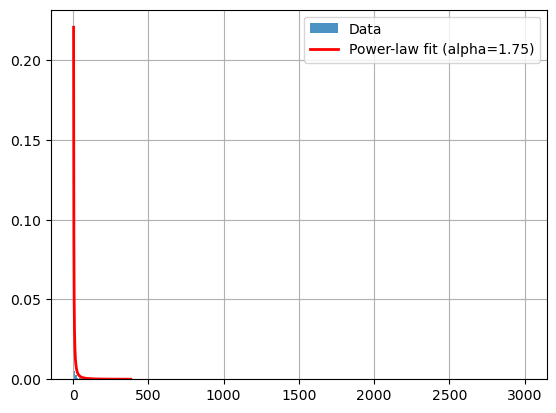

Power-law alpha: 1.7526868677546794
Power-law xmin: 3.0


In [11]:
# Extract the component sizes
connected_components = list(nx.connected_components(Graphs[-1]))
component_sizes = np.array([len(component) for component in connected_components])

# Plot histogram of component sizes
fig, ax = plt.subplots()
bins = np.arange(1, 3000, 2)
ax.hist(component_sizes, bins=bins, density=True, alpha=0.8, label='Data')
plt.grid()

# Fit the power-law distribution to the data
fit = powerlaw.Fit(component_sizes, discrete=True)

# Generate values for plotting the fitted power-law
x_vals = np.arange(fit.xmin, max(component_sizes))
powerlaw_vals = fit.power_law.pdf(x_vals)

# Plot the fitted power-law distribution
ax.plot(x_vals, powerlaw_vals, 'r-', lw=2, label=f'Power-law fit (alpha={fit.alpha:.2f})')

# Add legend
ax.legend()

plt.show()

# Output some goodness-of-fit statistics
print(f"Power-law alpha: {fit.alpha}")
print(f"Power-law xmin: {fit.xmin}")

In [52]:
fig, ax = plt.subplots()

def update(frame):
    ax.clear()  # Clear the previous frame's plot
    connected_components = list(nx.connected_components(Graphs[frame]))
    component_sizes = np.array([len(component) for component in connected_components])
    ax.hist(component_sizes, bins=np.arange(1, 3000, 2), alpha = 0.8)
    ax.set_xlabel('Floe Size')
    ax.set_ylabel('# Floes')
    ax.set_ylim(0,415)
    ax.set_yscale('log')
    ax.grid()

# Create the animation with FuncAnimation
anim = FuncAnimation(fig, update, frames=len(Graphs), repeat=False)

# Save the animation as a GIF
anim.save('gifs/graphs/shear_test_005_damp_fsd_1m_balls.gif', writer='pillow', fps=3)

plt.close(fig)  # Close the figure to avoid display issues

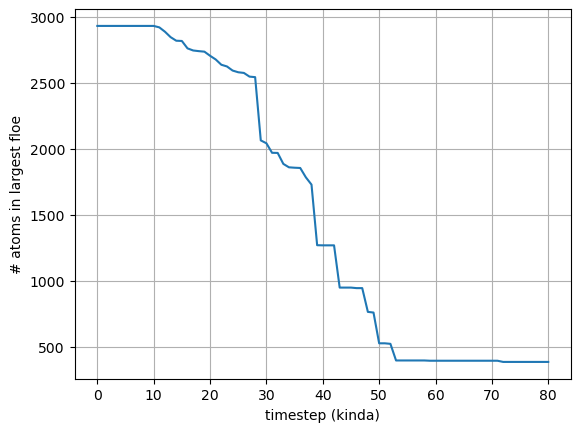

In [42]:
max_frag_size = []
for G in Graphs:
    connected_components = list(nx.connected_components(G))
    component_sizes = np.array([len(component) for component in connected_components])
    max_frag_size.append(component_sizes.max())
plt.plot(max_frag_size)
plt.grid()
plt.ylabel('# atoms in largest floe')
plt.xlabel('timestep (kinda)')
plt.show()


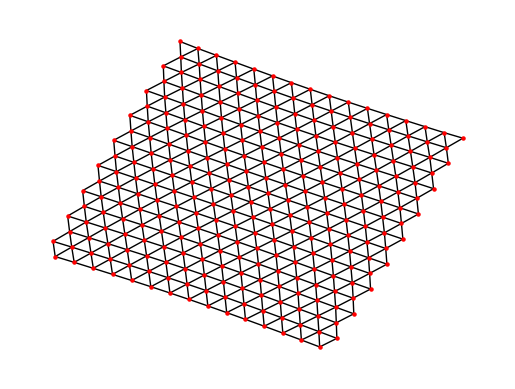

In [15]:
fig, ax = plt.subplots()


def update(frame):
    ax.clear()
    nx.draw(Graphs[frame], ax = ax, node_size=5, node_color = 'red', pos = nx.kamada_kawai_layout(Graphs[0]))

anim = FuncAnimation(fig, update, frames = len(Graphs))
anim.save('gifs/graphs/shear_test_005_damp_kamada_graph_constant_pos_code_test.gif', writer='pillow', fps = 5)